## Interest Rate

In [39]:
import pandas as pd

In [40]:
interest_rates = pd.read_csv('../data/interest_rates.csv')
print(interest_rates)

           DATE  FEDFUNDS
0    1954-07-01      0.80
1    1954-08-01      1.22
2    1954-09-01      1.07
3    1954-10-01      0.85
4    1954-11-01      0.83
..          ...       ...
827  2023-06-01      5.08
828  2023-07-01      5.12
829  2023-08-01      5.33
830  2023-09-01      5.33
831  2023-10-01      5.33

[832 rows x 2 columns]


In [41]:
def extract_year_month(date:str):
    year,month,day = date.split('-')
    return year,month

for date in interest_rates['DATE']:
    y,m = extract_year_month(date)
    print(f'original date: {date}\textracted year: {y}\textracted month:{m}')


original date: 1954-07-01	extracted year: 1954	extracted month:07
original date: 1954-08-01	extracted year: 1954	extracted month:08
original date: 1954-09-01	extracted year: 1954	extracted month:09
original date: 1954-10-01	extracted year: 1954	extracted month:10
original date: 1954-11-01	extracted year: 1954	extracted month:11
original date: 1954-12-01	extracted year: 1954	extracted month:12
original date: 1955-01-01	extracted year: 1955	extracted month:01
original date: 1955-02-01	extracted year: 1955	extracted month:02
original date: 1955-03-01	extracted year: 1955	extracted month:03
original date: 1955-04-01	extracted year: 1955	extracted month:04
original date: 1955-05-01	extracted year: 1955	extracted month:05
original date: 1955-06-01	extracted year: 1955	extracted month:06
original date: 1955-07-01	extracted year: 1955	extracted month:07
original date: 1955-08-01	extracted year: 1955	extracted month:08
original date: 1955-09-01	extracted year: 1955	extracted month:09
original d

In [42]:
SBA_vals = pd.read_csv('../SBAnational.csv')
print(SBA_vals)


/var/folders/nt/9wb2rhv97959gh0yy716ljlw0000gn/T/ipykernel_6119/678065440.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  SBA_vals = pd.read_csv('../SBAnational.csv')


        LoanNr_ChkDgt                            Name             City State  \
0          1000014003                  ABC HOBBYCRAFT       EVANSVILLE    IN   
1          1000024006     LANDMARK BAR & GRILLE (THE)        NEW PARIS    IN   
2          1000034009           WHITLOCK DDS, TODD M.      BLOOMINGTON    IN   
3          1000044001   BIG BUCKS PAWN & JEWELRY, LLC     BROKEN ARROW    OK   
4          1000054004     ANASTASIA CONFECTIONS, INC.          ORLANDO    FL   
...               ...                             ...              ...   ...   
899159     9995573004                    FABRIC FARMS  UPPER ARLINGTON    OH   
899160     9995603000                    FABRIC FARMS         COLUMBUS    OH   
899161     9995613003    RADCO MANUFACTURING CO.,INC.      SANTA MARIA    CA   
899162     9995973006           MARUTAMA HAWAII, INC.         HONOLULU    HI   
899163     9996003010  PACIFIC TRADEWINDS FAN & LIGHT           KAILUA    HI   

          Zip                          

In [43]:
SBA_vals['ApprovalDate'].value_counts().head(20)


ApprovalDate
7-Jul-93     1131
30-Jan-04    1032
8-Jul-93      780
4-Oct-04      658
30-Sep-03     608
30-Jun-05     572
18-Apr-05     534
6-Jul-93      523
21-Jan-05     498
27-Sep-02     497
22-Aug-03     490
19-Dec-03     478
9-Feb-05      477
30-Sep-97     466
7-Nov-03      458
14-Nov-03     457
6-Oct-04      456
6-Dec-04      452
29-Sep-05     447
24-Sep-02     445
Name: count, dtype: int64

In [75]:
# For some reason the SBA years are only 2 digits, so a value like '99', despite being
# earlier than something like '06' will show up and be sorted as being later
# so sorting by if it's greater than '30' and adding '19' before it, else adding '20'
# before it should set the values appropriately
SBA_years = SBA_vals['ApprovalDate'].apply(lambda s : s.split('-')[2])
SBA_years = SBA_years.apply(lambda s : int('19' + s) if s > '30' else int('20' + s))


print(f'min year: {SBA_years.min()}\tmax year: {SBA_years.max()}')

# Sort the number of approvals by year
val_counts = pd.DataFrame(SBA_years.value_counts()).sort_values(by='ApprovalDate')
val_counts.rename(columns={'ApprovalDate':'year'})
print(f'min approvals: {val_counts["count"].min()}\tmax approvals: {val_counts["count"].max()}')
print(f'vals: {val_counts}')



min year: 1961	max year:2014
min approvals: 1	max approvals: 77247
vals:               count
ApprovalDate       
1961              1
1964              1
1966              1
1967              3
1968              3
1969              4
1970             19
1971             15
1972             46
1973             46
1974             32
1975             49
1976             88
1977            141
1978            270
1979            361
1980            576
1981            598
1982            852
1983           1848
1984           1993
1985           1981
1986           2198
1987           2139
1988           4333
1989          13574
1990          15002
1991          16484
1992          21122
1993          25032
1994          37030
1995          41847
1996          40848
1997          37744
1998          35783
1999          37693
2000          36796
2001          38370
2002          47496
2003          62247
2004          71281
2005          75115
2006          77247
2007          67016
2008   

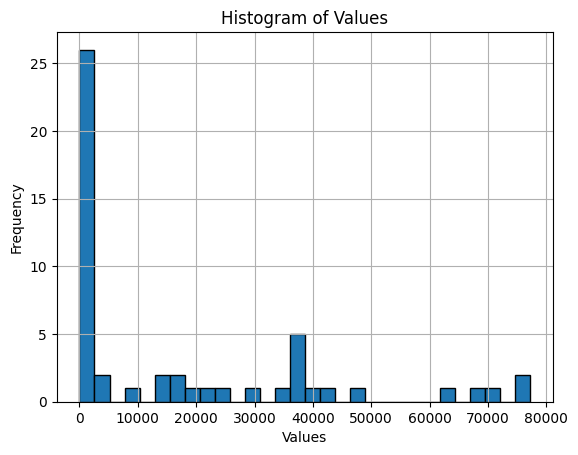

In [70]:
import matplotlib.pyplot as plt

val_counts['count'].hist(bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


In [ ]:
ser = pd.Series(data=SBA_vals['ApprovalDate'])

ser = ser.apply(lambda s : s.split('-')[1])

ser.unique()

months = {'Jan':31,'Feb':28,'Mar':31,'Apr':30,'May':31,'Jun':30,'Jul':31,'Aug':31,'Sep':30,'Oct':31,'Nov':30,'Dec':31}

print(list(months.keys()).index('Jan'))

0


In [ ]:


# SBA_date has a different format than the interest_rates dates
def get_fed_interest_rate_from_date(SBA_date):
